# Tutorial de Big Data (UdeSA) 2025
## Tutorial 13 - Modelos no lineales

**Objetivo:**
Que se familiaricen con modelos no lineales

### Modelos no lineales

En el curso nos enfocamos principalmente en modelos lineales, por ser simples y por sus ventajas en términos de interpretabilidad e inferencia

Sin embargo, el supuesto de linealidad es fuerte y a veces puede llevar a un menor poder predictivo. Ahora vamos a relajar el supuesto de linealidad.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import subplots
from ISLP import load_data
#%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

En este ejemplo, aplicamos los modelos no lineales a los datos de [Wage](https://islp.readthedocs.io/en/latest/datasets/Wage.html) (que contiene datos de 3000 hombres trabajadores de la region del Atlantico Medio en EEUU) para predecir `wage` (*workers raw wage*).

In [ ]:
dataset = load_data('Wage')
dataset.info()

In [ ]:
# Vamos a usar salario y edad
X = dataset['age']
y = dataset['wage']
print(y)

In [ ]:
fig, ax = subplots(figsize=(8,4))
ax.scatter(X, y, facecolor='gray', alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Regresión polinómica

In [ ]:
# Reshape para transformar x en un vector columna
X_train_ = X_train.values.reshape((-1, 1)) # Convertir Series a NumPy array y reshape

# Transformación polinomial
model_pol = PolynomialFeatures(include_bias=True, degree=4)
model_pol.fit(X_train_)
X_train_t = model_pol.transform(X_train_)

# Si en PolynomialFeatures ponemos include_bias=False, podemos agregar constante:
#X_train_t = sm.add_constant(X_train_t)

# Especificamos el modelo y ajustamos
model_pol4 = sm.OLS(y_train, X_train_t)
results = model_pol4.fit()

print(results.summary())

Estimamos el MSE de testeo

In [ ]:
X_test_t = model_pol.fit_transform(X_test.values.reshape((-1, 1)))

y_pred = results.predict(X_test_t)

print('ECM:', mean_squared_error(y_test, y_pred))

In [ ]:
# Generamos otras X y sus predicciones para graficar
X_seq = np.linspace(X.min(), X.max()).reshape(-1,1)
X_seq_t = model_pol.fit_transform(X_seq)
X_seq_pred = results.predict(X_seq_t)

fig, ax = subplots(figsize=(8,4))
ax.scatter(X, y, facecolor='gray', alpha=0.5)
ax.plot(X_seq, X_seq_pred, label='Reg. polinómica grado 4', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
#ax.legend(title='Poly', fontsize=15)

In [ ]:
results.predict(X_seq_t)

Podemos elegir el grado del polinimio por CV

#### Step function

In [ ]:
# Hacemos a la edad (X) discreta en función de cuantiles
cut_X = pd.qcut(X, 5) #qcut con 4 cuantiles
cut_X
# Nota pd.cut() permitiría hacer cortes no basados en cuantiles

In [ ]:
# y creamos dummies para cada quintil
q_X = pd.get_dummies(cut_X)
q_X

In [ ]:
# Primera columna
q_X.iloc[:, 0]

In [ ]:
q_X_train, q_X_test, y_train, y_test = train_test_split(q_X, y, test_size=0.2, random_state=0)

In [ ]:
#q_X_train_= sm.add_constant(q_X_train)

# Especificamos el modelo y ajustamos
q_model_pol4 = sm.OLS(y_train, q_X_train)
q_results = q_model_pol4.fit()

print(q_results.summary())

In [ ]:
q_pred =  q_results.predict(q_X_test).values

fig, ax = subplots(figsize=(8,4))
ax.scatter(X, y, facecolor='gray', alpha=0.5)
ax.plot(X_seq, results.predict(X_seq_t), label='Reg. polinómica grado 4', linewidth=2)
ax.scatter(X_test.values.reshape(-1,1), q_pred, facecolor='red', alpha=0.9, label="Step function")
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.legend(title='', fontsize=12)

#### Splines
Idea: usar polinomios y step function

Se determinan puntos de corte (knots) en $X$ y se ajustan distintas regresiones para cada segmento.

In [179]:
print('Min age:', min(dataset['age']), 'Max age:', max(dataset['age']))

Min age: 18 Max age: 80


In [181]:
from scipy.interpolate import BSpline

Usamos la funcion [BSpline()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.html) del modulo de `scipy`

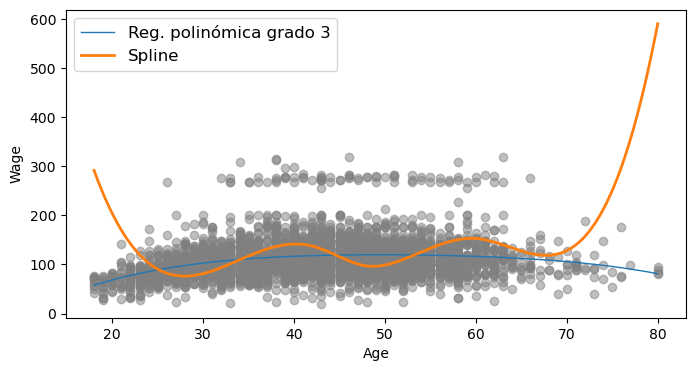

In [183]:
# Definimos knots y grado del polinomio
knots=[18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78]
degree = 3
t = [min(dataset['age'])] + knots + [max(dataset['age'])]
spl = BSpline(t, list(dataset['wage']), degree)

# Grilla para evaluar spline
x_smooth = np.linspace(min(dataset['age']), max(dataset['age']), 300)
y_smooth = spl(x_smooth)

# Plot
fig, ax = subplots(figsize=(8,4))
ax.scatter(X, y, facecolor='gray', alpha=0.5)
ax.plot(X_seq, results.predict(X_seq_t), label='Reg. polinómica grado 3', linewidth=1)
ax.plot(x_smooth, y_smooth, label='Spline', linewidth=2)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.legend(title='', fontsize=12)

Podemos notar que con span de 0.6 es más suave